In [8]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

%matplotlib inline

In [9]:
# Use the matplotlib plotting styles
CURR_PATH = pathlib.Path().parent
MPLSTYLE = CURR_PATH.joinpath("../plotstyle.mplstyle")
plt.style.use(MPLSTYLE)

In [10]:
def read_txt_pd(otype: str = "inclusive", charge: str = "nu") -> pd.DataFrame:
    
    path = f"clipped_nan_binned_sysevents_FASERv2_{otype}_{charge}.txt"
    fpath = CURR_PATH.joinpath(f"stat_syst_uncertainties/{path}")
    
    colnames = [
        "x_lower", 
        "x_upper", 
        "x_avg", 
        "Q2_lower", 
        "Q2_upper", 
        "Q2_avg", 
        "E_nu_lower", 
        "E_nu_upper", 
        "E_nu_avg", 
        "d^sigma/dxdQ2", 
        "N_events", 
        "N_events_errs", 
        "N_sys_errs", 
        "Percent_error_theta", 
        "Percent_error_Elepton", 
        "Percent_error_Ehadron", 
        "MC_Samples",
    ]
    
    return pd.read_csv(fpath, skiprows=2, delim_whitespace=True, names=colnames)

In [11]:
predictions = read_txt_pd()

In [19]:
def load_input(otype: str = "inclusive", charge: str = "nu"):
    # Read and Parse the central values
    path_cv = CURR_PATH.joinpath(
        f"pineappl_tables/diffxsec-FASERv2_{otype}_{charge}-a1_NNPDF40_nnlo_as_01180_iso.txt"
    )
    column = 3 if charge == "nu" else 4
    sigma = np.loadtxt(pathlib.Path(path_cv) , usecols=column, unpack=True, skiprows=1)
    
    # Extract the percentage error from the Lepton Energy
    df_predictions = read_txt_pd(otype=otype, charge=charge)
    # Compute the corresponding systematic errors
    syst_error = sigma * df_predictions["Percent_error_Elepton"].values
    # Extract the statistical events error
    num_events_error = df_predictions["N_events_errs"]
    stat_error = 1.0 / num_events_error * sigma
    
    # Add the statistical and systematic in quadrature
    comb_error = np.sqrt(syst_error**2 + stat_error**2)
    
    return stat_error, syst_error, comb_error, sigma

In [46]:
def fluctuate_data(central: np.ndarray, covmat: np.ndarray) -> np.ndarray:
    cholesky = np.linalg.cholesky(covmat)
    random_samples = np.random.randn(central.shape[0])
    
    shift_data = cholesky @ random_samples
    pseudodata = central + shift_data
    
    return pseudodata

In [95]:
def plot(cv, covmat_stat, covmat_sys, stat):
    covmat_tot = covmat_stat + covmat_sys
    # sigma_fluctuated_stat = np.random.multivariate_normal(cv, covmat_stat)
    # sigma_fluctuated_stat_sys = np.random.multivariate_normal(cv, covmat_tot)
    sigma_fluctuated_stat = fluctuate_data(cv, covmat_stat)
    sigma_fluctuated_stat_sys = fluctuate_data(cv, covmat_tot)

    x = np.arange(cv.size)

    fig, ax = plt.subplots(figsize=(5.5, 3.5))
    ax.errorbar(x, cv, yerr=np.sqrt(np.diag(covmat_tot)), fmt='.', label="not fluctuated")
    ax.plot(x, sigma_fluctuated_stat, marker='*', label="fluctuated, stat only", linestyle='None')
    ax.legend()
    ax.set_xlabel(r"$\rm{Bins}$")
    ax.set_ylabel(r"$d^2 \sigma /(dxdQ^2)$")
    fig.savefig("plots/level1_fluctuation_stat_only.pdf", bbox_inches="tight", dpi=350)
    plt.show()

    # now repeat includiong sys
    fig, ax = plt.subplots(figsize=(5.5, 3.5))
    ax.errorbar(x, cv, yerr=np.sqrt(np.diag(covmat_tot)), fmt='.', label="not fluctuated")
    ax.plot(x, sigma_fluctuated_stat_sys, marker='*', label="fluctuated, stat + sys", linestyle='None')
    ax.legend()
    ax.set_xlabel(r"$\rm{Bins}$")
    ax.set_ylabel(r"$d^2 \sigma /(dxdQ^2)$")
    fig.savefig("plots/level1_fluctuation_stat_syst.pdf", bbox_inches="tight", dpi=350)
    plt.show()

In [96]:
stat_error, syst_error, combined_error, sigma = load_input()
# Compute the covariance matrix
stat_covmat = np.diag(stat_error**2)
syst_covmat = np.diag(syst_error**2)
combined_covmat = np.diag(combined_error)

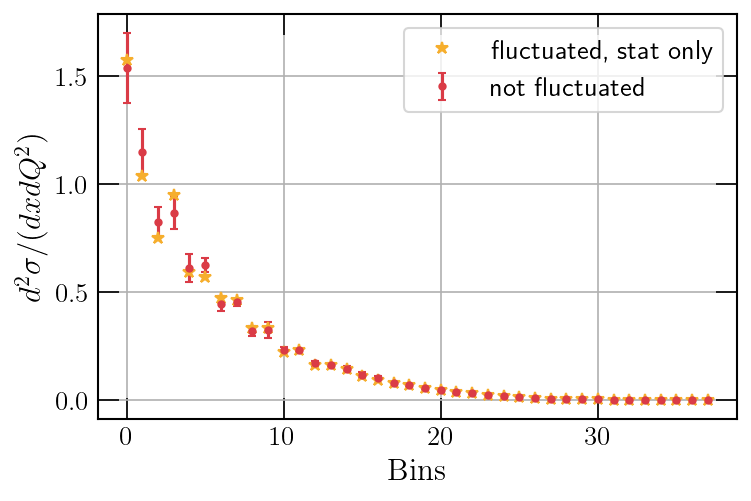

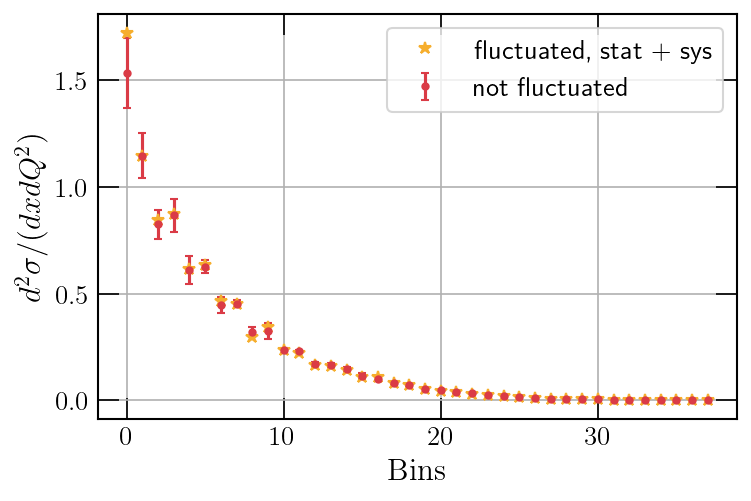

In [97]:
plot(sigma, stat_covmat, syst_covmat, stat_error)